In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import numpy as np
import os
import nibabel as nib
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

2025-05-18 06:15:47.010295: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 06:15:47.031761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747548947.052908    1187 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747548947.058325    1187 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747548947.078407    1187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))  # cast to float32 here
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model = load_model('unet_best.keras', custom_objects={'dice_coefficient': dice_coefficient}, safe_mode=False)


W0000 00:00:1747548951.903847    1187 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
def load_and_preprocess(patient_path, image_size=(128, 128)):
    modalities = ['flair', 't1', 't1ce', 't2']
    images = {}

    for modality in modalities:
        expected_suffix = f"_{modality}.nii.gz"
        matching_file = next(
            (f for f in os.listdir(patient_path) if f.lower().endswith(expected_suffix)), 
            None
        )

        if matching_file is None:
            raise ValueError(f"Missing modality: {modality}")

        file_path = os.path.join(patient_path, matching_file)
        print(f"Loading {modality} from {matching_file}")
        img = nib.load(file_path).get_fdata()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize
        img = np.rot90(img, k=1, axes=(0, 1))
        images[modality] = img

    # Stack images in consistent modality order
    stacked_images = np.stack([images[mod] for mod in modalities], axis=-1)  # (H, W, Slices, 4)
    stacked_images = np.transpose(stacked_images, (2, 0, 1, 3))  # (Slices, H, W, 4)

    # Resize each slice
    num_slices = stacked_images.shape[0]
    X = np.zeros((num_slices, image_size[0], image_size[1], 4), dtype=np.float32)
    for i in range(num_slices):
        X[i] = cv2.resize(stacked_images[i], image_size, interpolation=cv2.INTER_LINEAR)

    return X


In [4]:
new_patient_path = 'input/BraTS2021_00495'
X = load_and_preprocess(new_patient_path, image_size=(128, 128))

Loading flair from BraTS2021_00495_flair.nii.gz
Loading t1 from BraTS2021_00495_t1.nii.gz
Loading t1ce from BraTS2021_00495_t1ce.nii.gz
Loading t2 from BraTS2021_00495_t2.nii.gz


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


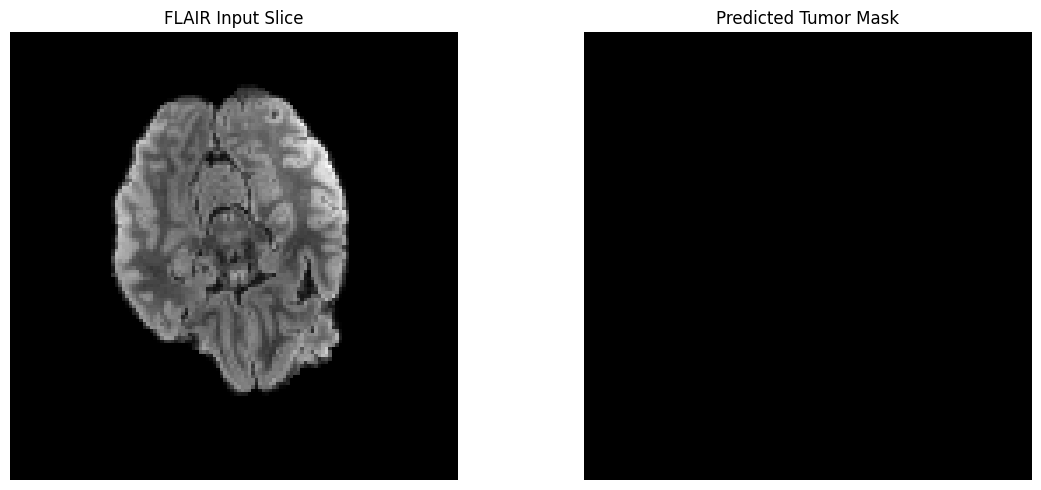

In [5]:
preds = model.predict(X)  # preds.shape = (num_slices, 128, 128, 1)
binary_masks = (preds > 0.5).astype(np.uint8)  # shape: (num_slices, 128, 128, 1)

slice_index = 60
input_slice = X[slice_index, :, :, 0]  # Use flair modality (channel 0)
predicted_mask = binary_masks[slice_index, :, :, 0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("FLAIR Input Slice")
plt.imshow(input_slice, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Tumor Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
